In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from AdversarialExamples import AdversarialExamples

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# import cifar10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [4]:
# make adversarial training set
eps = 0.1
x_train_adv = x_train + eps * np.sign(np.random.rand(*x_train.shape) - 0.5)
x_train_adv = np.clip(x_train_adv, 0, 1)

# make train dataset
# Create the dataset from one-hot encoded labels
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot)) # original dataset
# adv_train_dataset = tf.data.Dataset.from_tensor_slices((x_train_adv, y_train_one_hot)) # adversarial train set
# augmented_train_dataset = train_dataset.map(AdversarialExamples.augment, num_parallel_calls=tf.data.AUTOTUNE) # augmented train set

# train_dataset = train_dataset.concatenate(adv_train_dataset).concatenate(augmented_train_dataset)

train_dataset = train_dataset.shuffle(buffer_size=5000).batch(64).prefetch(tf.data.AUTOTUNE)

$\frac{e^{z_i/T}}{\sum_{j=0}^{n-1} e^{z_i/T}}$ n, is the number of logits. Note the T denominator

In [5]:
# Make softmax temperature layer
class SoftmaxTemperature(tf.keras.layers.Layer):
    def __init__(self, temperature=1.0, **kwargs):
        super(SoftmaxTemperature, self).__init__(**kwargs)
        self.temperature = temperature

    def call(self, inputs):
        logits = inputs / self.temperature
        return tf.nn.softmax(logits)

In [12]:
# note how avrying temperature changes the resulting distribution. T --> infinity, dist'n --> uniform (because 1/T term dominates z_i)
temperature = 0.00000001
test_model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(5),
    SoftmaxTemperature(temperature=temperature)
])

arr = np.array([0, 1, 2, 3, 4], ndmin=2)
print(arr)
test_model(arr)

[[0 1 2 3 4]]


<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 0., 1., 0., 0.]], dtype=float32)>

In [8]:
def get_distillation_model(temperature):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
        SoftmaxTemperature(temperature=temperature)
    ])

    model.build()
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

    return model

New distillation model - identical architecture, only with softmax temperature instead of regular softmax activation on the last layer

In [8]:
temperature=50
model = get_distillation_model(temperature=temperature)
model(x_train[:1])

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.10010763, 0.09991062, 0.10003397, 0.09980355, 0.09999803,
        0.09988521, 0.10020497, 0.09997255, 0.10004214, 0.10004143]],
      dtype=float32)>

Epoch 1/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.5091 - loss: 1.3976 - val_accuracy: 0.7019 - val_loss: 0.8538
Epoch 2/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7375 - loss: 0.7482 - val_accuracy: 0.7464 - val_loss: 0.7343
Epoch 3/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.7781 - loss: 0.6413 - val_accuracy: 0.8130 - val_loss: 0.5406
Epoch 4/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7983 - loss: 0.5792 - val_accuracy: 0.8224 - val_loss: 0.5204
Epoch 5/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8119 - loss: 0.5376 - val_accuracy: 0.8076 - val_loss: 0.5488
Epoch 6/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8212 - loss: 0.5099 - val_accuracy: 0.8138 - val_loss: 0.5371
Epoch 7/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8300 - loss: 0.4867 - val_accuracy: 0.8334 - val_loss: 0.4961
Epoch 8/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8381 - loss: 

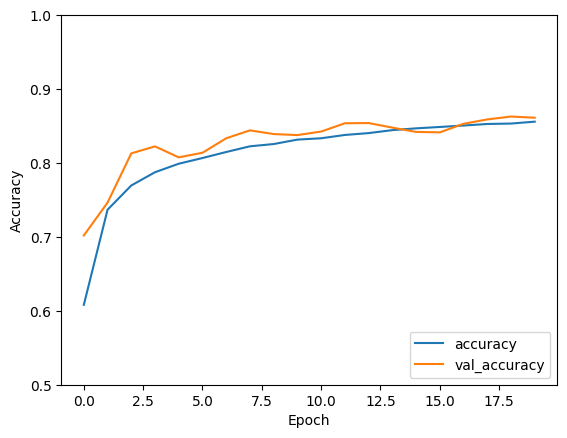

In [ ]:
history = model.fit(train_dataset, epochs=10,
          validation_data=(x_test, y_test_one_hot),
          batch_size=64)

loss, accuracy = model.evaluate(x_test, y_test_one_hot, verbose=1)
print(loss, accuracy)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [14]:
model.save_weights("first_distillation_model.weights.h5")

In [37]:
# create soft train labels from model
def change_labels_to_soft(image, label):
    new_label = model(image)
    return image, new_label

soft_label_dataset = train_dataset.map(change_labels_to_soft, num_parallel_calls=tf.data.AUTOTUNE)

distilled_model = get_distillation_model(temperature)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
for images, labels in soft_label_dataset.take(1):
    print(images.shape)
    print(labels.shape)
    print(labels[0])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(64, 32, 32, 3)
(64, 10)
tf.Tensor(
[1.2946185e-05 1.9793225e-07 3.6183220e-08 1.4451600e-06 7.5242017e-09
 3.8336097e-08 2.3467701e-05 3.7620413e-09 9.9996173e-01 9.0945690e-08], shape=(10,), dtype=float32)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Epoch 1/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 216s 88ms/step - accuracy: 0.5339 - loss: 1.3720 - val_accuracy: 0.7440 - val_loss: 0.7437
Epoch 2/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 197s 84ms/step - accuracy: 0.7710 - loss: 0.7411 - val_accuracy: 0.7914 - val_loss: 0.6137
Epoch 3/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 203s 85ms/step - accuracy: 0.8088 - loss: 0.6561 - val_accuracy: 0.8055 - val_loss: 0.5650
Epoch 4/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - accuracy: 0.8253 - loss: 0.6189 - val_accuracy: 0.8239 - val_loss: 0.5216
Epoch 5/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 201s 83ms/step - accuracy: 0.8384 - loss: 0.5941 - val_accuracy: 0.8105 - val_loss: 0.5560
Epoch 6/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - accuracy: 0.8430 - loss: 0.5798 - val_accuracy: 0.8348 - val_loss: 0.4769
Epoch 7/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 202s 85ms/step - accuracy: 0.8490 - loss: 0.5682 - val_accuracy: 0.8241 - val_loss: 0.5127
Epoch 8/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - accuracy: 

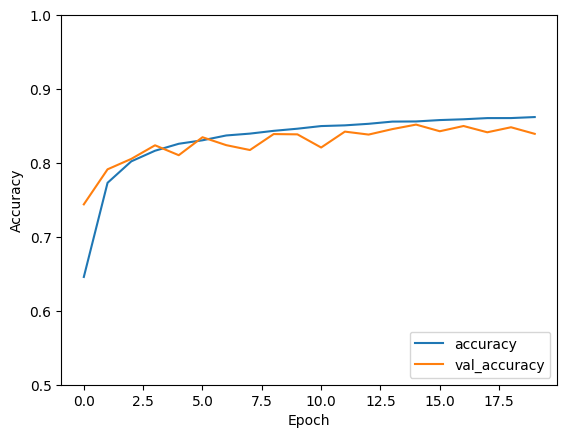

In [ ]:
history = distilled_model.fit(soft_label_dataset, epochs=10,
          validation_data=(x_test, y_test_one_hot),
          batch_size=64)

loss, accuracy = distilled_model.evaluate(x_test, y_test_one_hot, verbose=1)
print(loss, accuracy)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [40]:
distilled_model.save_weights("second_distillation_model.weights.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3912 - loss: 2.2704


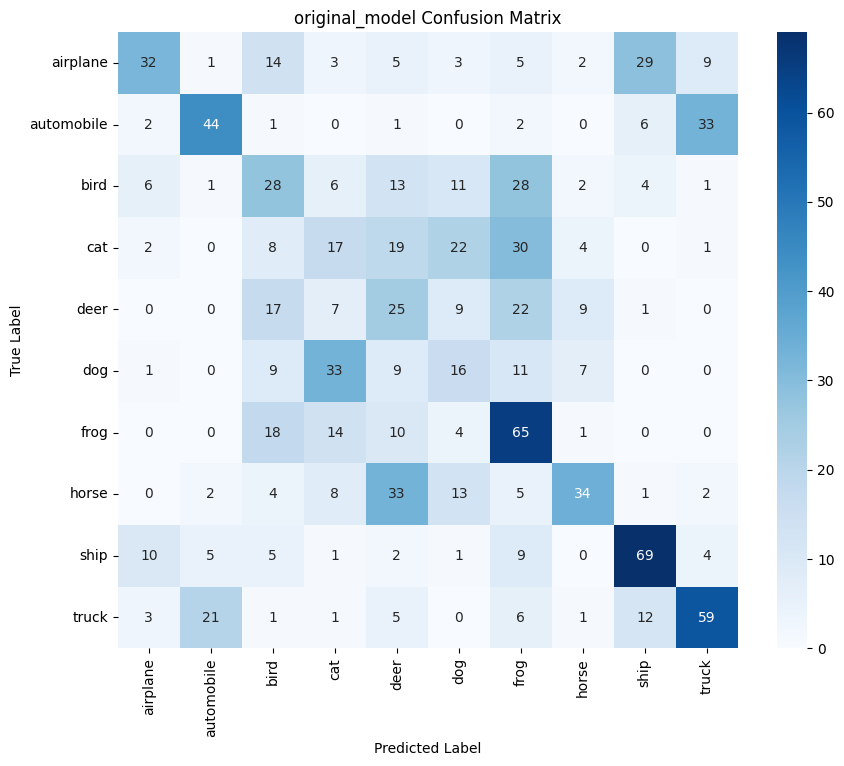

In [43]:
n = 1000
x_adv_test = AdversarialExamples.create_fgsm_dataset(distilled_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
# x_adv_test = x_test[:n]
loss, accuracy = distilled_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=1)

predictions = tf.argmax(distilled_model(x_adv_test), axis=1)
conf_mat = tf.math.confusion_matrix(y_test[:n], predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("original_model Confusion Matrix")
plt.show()

In [40]:
temperature = 50
test_model = get_distillation_model(temperature=temperature)
test_model.load_weights("defensive_distillation/first_distillation_model.weights.h5")

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
test_model(x_test[:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[4.8704832e-03, 8.8506436e-04, 2.4989997e-03, 8.0807954e-01,
        1.4407375e-04, 2.8440477e-02, 1.5324816e-01, 2.5579520e-04,
        1.5182032e-03, 5.9222664e-05]], dtype=float32)>

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0475 - loss: 6.7703 


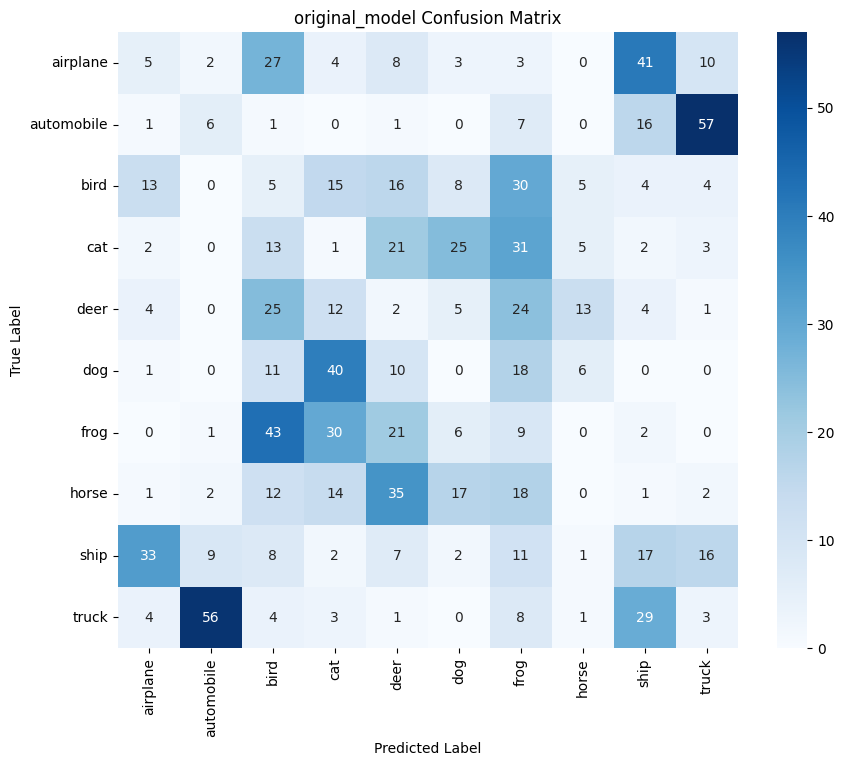

In [43]:
n = 1000
x_adv_test = AdversarialExamples.create_fgsm_dataset(test_model, x_test[:n], y_test_one_hot[:n], eps=0.05)
# x_adv_test = x_test[:n]
loss, accuracy = test_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=1)

predictions = tf.argmax(test_model(x_adv_test), axis=1)
conf_mat = tf.math.confusion_matrix(y_test[:n], predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("original_model Confusion Matrix")
plt.show()

In [24]:
distillationo_test_model = get_distillation_model(temperature=1)
distillationo_test_model.load_weights("defensive_distillation/Attempt 1/second_distillation_model.weights.h5")

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
n = 1000
x_adv_test = AdversarialExamples.create_fgsm_dataset(distillationo_test_model, x_test[:n], y_test_one_hot[:n], eps=0.0)
# x_adv_test = x_test[:n]
loss, accuracy = distillationo_test_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=1)

predictions = tf.argmax(distillationo_test_model(x_adv_test), axis=1)
conf_mat = tf.math.confusion_matrix(y_test[:n], predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("original_model Confusion Matrix")
plt.show()

NameError: name 'distillationo_test_model' is not defined

What happens if we mess with the logits of another model that did not undergo defensive distillation?

In [26]:
no_distillation_test_model = get_distillation_model(temperature=0.01)
no_distillation_test_model.load_weights("fgsm_adversarial_learning/fgsm_adversary_model.weights.h5")

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8385 - loss: 37.1493


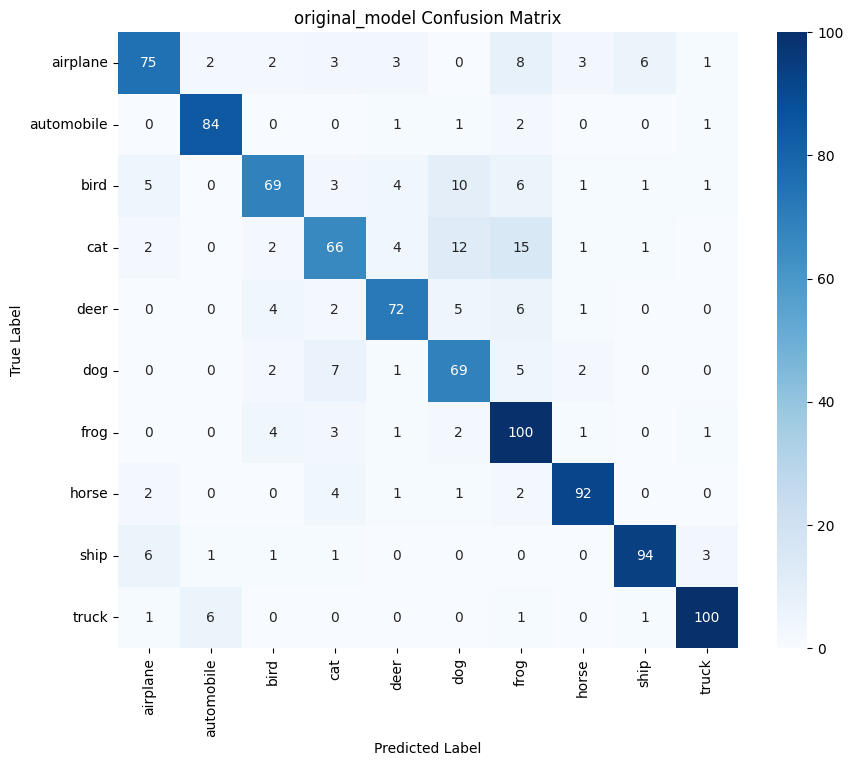

In [29]:
n = 1000
x_adv_test = AdversarialExamples.create_fgsm_dataset(no_distillation_test_model, x_test[:n], y_test_one_hot[:n], eps=0.3)
# x_adv_test = x_test[:n]
loss, accuracy = no_distillation_test_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=1)

predictions = tf.argmax(no_distillation_test_model(x_adv_test), axis=1)
conf_mat = tf.math.confusion_matrix(y_test[:n], predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("original_model Confusion Matrix")
plt.show()